# Anomaly Detection

Wallaroo provides multiple methods of analytical analysis to verify that the data received and generated during an inference is accurate.  This tutorial will demonstrate how to use anomaly detection to track the outputs from a sample model to verify that the model is outputting acceptable results.

Anomaly detection allows organizations to set validation parameters.  A **validation** is added to a pipeline to test data based on a specific that triggers as an anomaly as part of the [InferenceResult](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/#inferenceresult-object) object.  

This tutorial will follow this process in setting up a validation to a pipeline and examining the results:

1. Create a workspace and upload the sample model.
1. Establish a pipeline and add the model as a step.
1. Add a validation to the pipeline.
1. Perform inferences and display anomalies through the InferenceResult object and the pipeline log files.

This tutorial provides the following:

* Housing model: `./models/housing.zip` - a pretrained model used to determine standard home prices.
* Test Data:  `./data` - sample data.

This demonstration assumes that a Wallaroo instance has been installed.

## Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [24]:
import wallaroo
from wallaroo.object import EntityNotFoundError
import os

### Connect to Wallaroo Instance

The following command will create a connection to the Wallaroo instance and store it in the variable `wl`.

In [25]:
wl = wallaroo.Client()

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace for all other commands.


pipeline_name = 'abtestpipeline'
model_name = 'alohamodel'

In [ ]:
workspace_name = 'anomalyexample'

def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

## Upload The Model

The housing model will be uploaded for use in our pipeline.

In [26]:
housing_model = wl.upload_model("anomaly-housing-model", "./models/housing.zip").configure("tensorflow")

### Build the Pipeline and Validation

The pipeline `anomaly-housing-pipeline` will be created and the `anomaly-housing-model` added as a step.  A validation will be created for outputs greater 100.0 - interpreted as houses with a value greater than 100 million dollars - with the `add_validation` method.  When houses greater than this value are detected, the InferenceObject will flag it in the `check_failures` array with the message "price too high".

Once complete, the pipeline will be deployed and ready for inferences.


In [27]:
p = wl.build_pipeline('anomaly-housing-pipeline')
p = p.add_model_step(housing_model)
p = p.add_validation('price too high', housing_model.outputs[0][0] < 100.0)
pipeline = p.deploy()


Waiting for deployment - this will take up to 45s ...... ok


### Testing

Two data points will be fed used for an inference.

The first, labeled `response_normal`, will not trigger an anomaly detection.  The other, labeled `response_trigger`, will trigger the anomaly detection, which will be shown in the InferenceResult `check_failures` array.  

Note that multiple validations can be created to allow for multiple anomalies detected.

In [28]:
test_input = {"dense_16_input":[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145,  0.03550877, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]}
response_normal = pipeline.infer(test_input)
print("\n")
print(response_normal)



[InferenceResult({'check_failures': [],
 'elapsed': 15045447,
 'model_name': 'anomaly-housing',
 'model_version': 'c3cf1577-6666-48d3-b85c-5d4a6e6567ea',
 'original_data': {'dense_16_input': [[0.02675675,
                                       0.0,
                                       0.02677953,
                                       0.0,
                                       0.0010046,
                                       0.00951931,
                                       0.14795322,
                                       0.0027145,
                                       0.03550877,
                                       0.98536841,
                                       0.02988655,
                                       0.04031725,
                                       0.04298041]]},
 'outputs': [{'Float': {'data': [10.349835395812988], 'dim': [1, 1], 'v': 1}}],
 'pipeline_name': 'anomaly-housing-model',
 'time': 1651257033662})]


In [29]:
test_input = {"dense_16_input":[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145,  2, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]}
response_trigger = pipeline.infer(test_input)
print("\n")
print(response_trigger)



[InferenceResult({'check_failures': [{'False': {'expr': 'anomaly-housing.outputs[0][0] < 100'}}],
 'elapsed': 15110549,
 'model_name': 'anomaly-housing',
 'model_version': 'c3cf1577-6666-48d3-b85c-5d4a6e6567ea',
 'original_data': {'dense_16_input': [[0.02675675,
                                       0.0,
                                       0.02677953,
                                       0.0,
                                       0.0010046,
                                       0.00951931,
                                       0.14795322,
                                       0.0027145,
                                       2,
                                       0.98536841,
                                       0.02988655,
                                       0.04031725,
                                       0.04298041]]},
 'outputs': [{'Float': {'data': [350.46990966796875], 'dim': [1, 1], 'v': 1}}],
 'pipeline_name': 'anomaly-housing-model',
 'time': 1651257043312

### Multiple Tests

With the initial tests run, we can run the inferences against a larger set of data and identify anomalies that appear versus the expected results.  These will be displayed into a graph so we can see where the anomalies occur.  In this case, with the house that came in at $350 million - outside of our validation range.

In [30]:
from data import test_data_anomaly
responses_anomaly =[]
for nth in range(400):
    responses_anomaly.extend(pipeline.infer(test_data_anomaly.data[nth]))

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

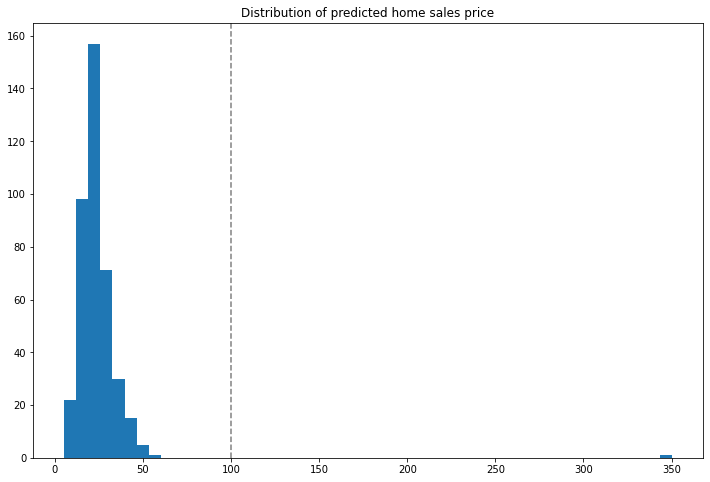

In [32]:
houseprices = [r.raw['outputs'][0]['Float']['data'][0] for  r in responses_anomaly]
hdf = pd.DataFrame({'sell_price': houseprices})
hdf.hist(column='sell_price', bins=50, grid=False, figsize=(12,8))
plt.axvline(x=100, color='gray', ls='--')
_ = plt.title('Distribution of predicted home sales price')

### How To Check For Anomalies

There are two primary methods for detecting anomalies with Wallaroo:

* As demonstrated in the example above, from the `InferenceObject` `check_failures` array in the output of each inference to see if anything has happened.
* The other method is to view pipeline's logs and see what anomalies have been detected.

In the following example, the outputs from the `responses_anomaly` array generated earlier from the set of inferences will be displayed.  These are a set of `InferenceResults` objects and the `data` attribute.

In [33]:
for r in responses_anomaly[0:10]:
    print(r.raw['original_data']['dense_16_input'])
    print("Homes sell price is : ", r.raw['outputs'][0]['Float']['data'][0])
    print("-----------------------------------")

[[0.0024118992380233097, 0.0, 0.01592968575097953, 0.0, 0.0010528465520917676, 0.0120196719757391, 0.17945358517995366, 0.007782649540917751, 0.007827855405886746, 0.6007879024018078, 0.04109624088090542, 0.7767189526491124, 0.03663436329954997]]
Homes sell price is :  19.22847557067871
-----------------------------------
[[4.0792305033858854e-05, 0.15458728366069616, 0.003803784070681371, 0.0, 0.0007776208814447139, 0.01425950580191391, 0.0294184285269446, 0.011748633558212906, 0.0037475705129865738, 0.6520772692596637, 0.02754464327045131, 0.7408572147123157, 0.005827472147694121]]
Homes sell price is :  35.99686813354492
-----------------------------------
[[0.006345055280061724, 0.0, 0.02344637451341859, 0.0, 0.0008173846584512227, 0.006438037642634828, 0.12953798073711928, 0.0017260935933221145, 0.031089115376908623, 0.8627229517092144, 0.026166672108898097, 0.4864410252640302, 0.004222938172030088]]
Homes sell price is :  44.759674072265625
-----------------------------------
[[8

#### View Logs

The other method of viewing anomalies is through the pipeline's logs.  The flag `valid=False` will show any validations that were flagged as `False` - in this case, houses that were above 100 million in value.

In [34]:
pipeline.logs(valid=False)


Timestamp,Output,Input,Anomalies
2022-29-Apr 01:18:57,[array([[350.46990967]])],"[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145, 2, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]",1
2022-29-Apr 01:18:58,[array([[350.46990967]])],"[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145, 2, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]",1
2022-29-Apr 15:01:45,[array([[350.46990967]])],"[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145, 2, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]",1
2022-29-Apr 15:01:50,[array([[350.46990967]])],"[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145, 2, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]",1
2022-29-Apr 18:30:43,[array([[350.46990967]])],"[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145, 2, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]",1
2022-29-Apr 18:31:36,[array([[350.46990967]])],"[[0.02675675, 0.0, 0.02677953, 0.0, 0.0010046, 0.00951931, 0.14795322, 0.0027145, 2, 0.98536841, 0.02988655, 0.04031725, 0.04298041]]",1


### Undeploy The Pipeline

With the example complete, we undeploy the pipeline to return the resources back to the Wallaroo instance.

In [ ]:
pipeline.undeploy()